# Final Project: Drone vs Bird

In [545]:
# LOAD RELEVANT LIBRARIES
import warnings; warnings.filterwarnings("ignore")
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as xt
from PIL import Image
from random import randrange
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report

## Reorganize files

In [98]:
import shutil

DIR = "valid"
source_dir = os.path.join(DIR, "images")
dest_dir_a = os.path.join(DIR,  "bird")
dest_dir_b = os.path.join(DIR,  "drone")

In [100]:
for filename in os.listdir(source_dir):
    source_path = os.path.join(source_dir, filename)
    if os.path.isfile(source_path):
        if 'BV' in filename:
            dest_path = os.path.join(dest_dir_a, filename)
            shutil.move(source_path, dest_path)
        elif 'DV' in filename:
            dest_path = os.path.join(dest_dir_b, filename)
            shutil.move(source_path, dest_path)

## Load data

In [ ]:
# # deleting the ipynb_checkpoints hidden folder
# import shutil

# checkpoints_path = "test/.ipynb_checkpoints"
# if os.path.exists(checkpoints_path):
#     shutil.rmtree(checkpoints_path)


In [409]:
data_dir = pathlib.Path('train').with_suffix('')
train_ds= tf.keras.utils.image_dataset_from_directory(
     data_dir, seed=0)

data_dir = pathlib.Path('valid').with_suffix('')
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, seed=0)

class_names = train_ds.class_names
print('Names of classes:', class_names)
num_classes = len(class_names)
print('There are', num_classes, 'classes.') 

Found 1387 files belonging to 2 classes.
Found 353 files belonging to 2 classes.
Names of classes: ['bird', 'drone']
There are 2 classes.


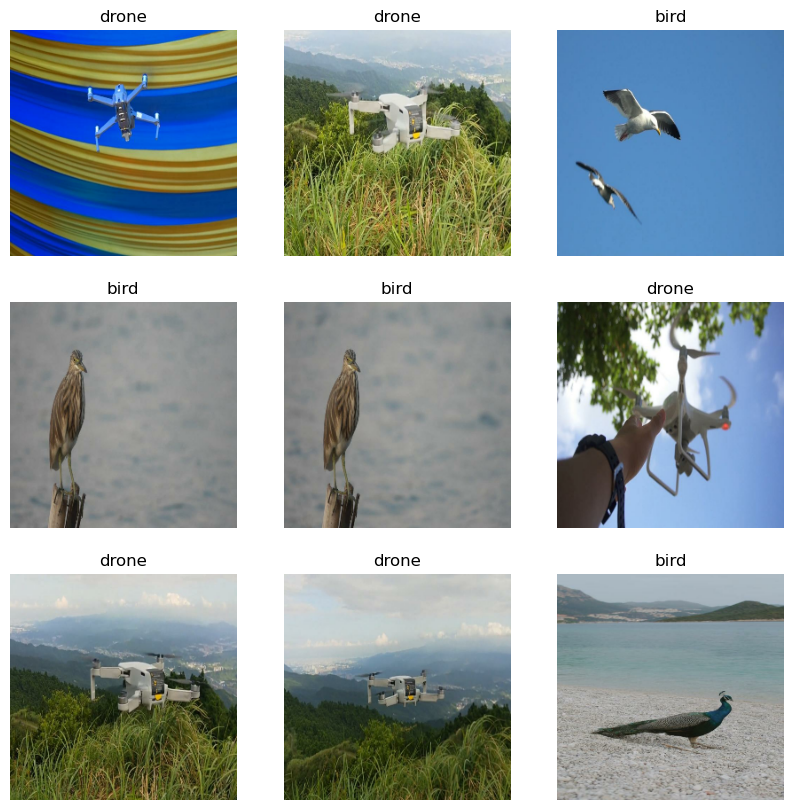

In [540]:
# DISPLAY EXAMPLE IMAGES
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data Augmentation (failed)

In [11]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#   tf.keras.layers.RandomRotation(0.2),
# ])
# len(list(train_ds))

# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

44

## Training Model

### My own CNN

In [554]:
NUM_EPOCHS = 5
IMAGE_SIZE = (125, 125)  # (Height, Width)

simple_CNN_model = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(200, 3, activation='relu'), 
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.Conv2D(5, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile & train 
simple_CNN_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

history = simple_CNN_model.fit(train_ds, validation_data=val_ds, batch_size=32, epochs=NUM_EPOCHS)

Epoch 1/5
44/44 [==============================] - 89s 2s/step - loss: 0.4194 - accuracy: 0.7736 - val_loss: 1.5838 - val_accuracy: 0.7507
Epoch 2/5
44/44 [==============================] - 87s 2s/step - loss: 0.1048 - accuracy: 0.9640 - val_loss: 4.2494 - val_accuracy: 0.7054
Epoch 3/5
44/44 [==============================] - 87s 2s/step - loss: 0.1777 - accuracy: 0.9539 - val_loss: 4.1343 - val_accuracy: 0.6714
Epoch 4/5
44/44 [==============================] - 89s 2s/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 7.3759 - val_accuracy: 0.5297
Epoch 5/5
44/44 [==============================] - 90s 2s/step - loss: 0.0999 - accuracy: 0.9813 - val_loss: 7.3040 - val_accuracy: 0.4703


In [556]:
# F1 SCORE AND CLASSIFICATION REPORT FOR VALIDATION DATA
y_pred1 = simple_CNN_model.predict(val_ds)
y_pred = np.round(y_pred1) # Binary
    
X_train = np.concatenate(list(train_ds.map(lambda x, y: x)))
y_train = np.concatenate(list(train_ds.map(lambda x, y: y)))
X_val = np.concatenate(list(val_ds.map(lambda x, y: x)))
y_val = np.concatenate(list(val_ds.map(lambda x, y: y)))

print('F1 score: ', f1_score(y_val, y_pred, average="weighted"))
print(classification_report(y_val, y_pred, target_names=class_names))

12/12 [==============================] - 5s 406ms/step
F1 score:  0.3725769074074843
              precision    recall  f1-score   support

        bird       0.39      0.81      0.52       137
       drone       0.60      0.18      0.28       216

    accuracy                           0.42       353
   macro avg       0.49      0.50      0.40       353
weighted avg       0.52      0.42      0.37       353



### ResNet50 (Fine-tuning)

In [415]:
IMAGE_SIZE = (224, 224)  # (Height, Width)

# Use ResNet50 as base model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# Make last block of the base trainable:
for layer in base_model.layers[:165]:
    layer.trainable = False
for layer in base_model.layers[165:]:
    layer.trainable = True
    print(layer)

print('Last block of the conv_base is now trainable')

# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name, layer.trainable)

Last block of the conv_base is now trainable


#### testing # epochs

In [360]:
# Run the model for different
NUM_EPOCHS = 20

# Wrap the base model to fit the problem
model = tf.keras.Sequential([
        tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        tf.keras.layers.Rescaling(1./255),
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification, so 1 neuron with sigmoid activation
    ])
    
# Compile the model
model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
)

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

# Report results
y_pred1 = model.predict(val_ds)
y_pred = np.round(y_pred1) # Binary
y_val = np.concatenate(list(val_ds.map(lambda x, y: y)))
print('F1 score: ', f1_score(y_val, y_pred, average="weighted"))

Compiling a model with 20 epochs
Epoch 1/20
44/44 [==============================] - 64s 1s/step - loss: 0.1941 - accuracy: 0.9380 - val_loss: 3.5480 - val_accuracy: 0.7224
Epoch 2/20
44/44 [==============================] - 58s 1s/step - loss: 0.0137 - accuracy: 0.9978 - val_loss: 2.1036 - val_accuracy: 0.6147
Epoch 3/20
44/44 [==============================] - 58s 1s/step - loss: 0.0028 - accuracy: 0.9986 - val_loss: 1.7067 - val_accuracy: 0.7450
Epoch 4/20
44/44 [==============================] - 65s 1s/step - loss: 0.0917 - accuracy: 0.9805 - val_loss: 31.9838 - val_accuracy: 0.6459
Epoch 5/20
44/44 [==============================] - 71s 2s/step - loss: 0.0932 - accuracy: 0.9762 - val_loss: 30.1202 - val_accuracy: 0.6119
Epoch 6/20
44/44 [==============================] - 101s 2s/step - loss: 0.1948 - accuracy: 0.9596 - val_loss: 22.5667 - val_accuracy: 0.5892
Epoch 7/20
44/44 [==============================] - 78s 2s/step - loss: 0.0201 - accuracy: 0.9964 - val_loss: 5.0480 - val_

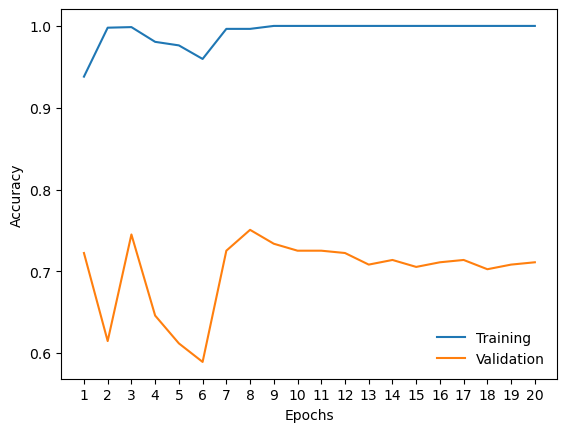

In [366]:
# PLOT HOW TRAINING AND VALIDATION ACCURACY THROUGHOUT TRAINING PROCESS
best_n_epochs = 20
plt.plot(range(1, best_n_epochs+1), history.history['accuracy'])
plt.plot(range(1, best_n_epochs+1), history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, best_n_epochs+1))
plt.legend(['Training', 'Validation'], frameon=False)
plt.show()

#### testing additional dense layer

In [421]:
# Add additional dense layer with n nodes, train, and report results on validation data
n_nodes = [10, 32, 64, 128, 200]

for n in n_nodes:
    print(f"Compiling a model with a dense layer with {n} nodes")
    # Create a new model
    model = tf.keras.Sequential([
        tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        tf.keras.layers.Rescaling(1./255),
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification, so 1 neuron with sigmoid activation
    ])
        
    # Compile the model
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=best_n_epochs)
    
    # Report results
    y_pred1 = model.predict(val_ds)
    y_pred = np.round(y_pred1) # Binary
    y_val = np.concatenate(list(val_ds.map(lambda x, y: y)))
    print('F1 score: ', f1_score(y_val, y_pred, average="weighted"))

Compiling a model with a dense layer with 10 nodes
Epoch 1/8
44/44 [==============================] - 61s 1s/step - loss: 0.0963 - accuracy: 0.9603 - val_loss: 9.9271 - val_accuracy: 0.3938
Epoch 2/8
44/44 [==============================] - 67s 2s/step - loss: 0.0084 - accuracy: 0.9993 - val_loss: 9.6764 - val_accuracy: 0.3909
Epoch 3/8
44/44 [==============================] - 58s 1s/step - loss: 4.0174e-04 - accuracy: 1.0000 - val_loss: 5.1706 - val_accuracy: 0.6289
Epoch 4/8
44/44 [==============================] - 66s 2s/step - loss: 0.0056 - accuracy: 0.9993 - val_loss: 3.2983 - val_accuracy: 0.7167
Epoch 5/8
44/44 [==============================] - 69s 2s/step - loss: 4.1591e-06 - accuracy: 1.0000 - val_loss: 3.8130 - val_accuracy: 0.7082
Epoch 6/8
44/44 [==============================] - 69s 2s/step - loss: 4.7950e-07 - accuracy: 1.0000 - val_loss: 4.1705 - val_accuracy: 0.7110
Epoch 7/8
44/44 [==============================] - 63s 1s/step - loss: 1.1701e-07 - accuracy: 1.0000 - 

#### + dropout

In [497]:
# Add a droput with the rate of 0.5, train for all node options, report results and save the best model 
n_nodes = [10, 32, 64, 128, 200]
best_model = None
best_score = 0
best_history = None

for n in n_nodes:
    print(f"Compiling a model with a dense layer with {n} nodes")
    # Create a new model
    model = tf.keras.Sequential([
        tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        tf.keras.layers.Rescaling(1./255),
        base_model,
        tf.keras.layers.Flatten(),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(n, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification, so 1 neuron with sigmoid activation
    ])
        
    # Compile the model
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=best_n_epochs)
    
    # Report results
    y_pred1 = model.predict(val_ds)
    y_pred = np.round(y_pred1) # Binary
    y_val = np.concatenate(list(val_ds.map(lambda x, y: y)))
    f1 =  f1_score(y_val, y_pred, average="weighted")
    print('F1 score: ', f1)
    if f1 > best_score:
        best_score = f1
        best_history = history
        

Compiling a model with a dense layer with 10 nodes
Epoch 1/8
44/44 [==============================] - 57s 1s/step - loss: 0.1754 - accuracy: 0.9546 - val_loss: 3.7036 - val_accuracy: 0.7564
Epoch 2/8
44/44 [==============================] - 59s 1s/step - loss: 0.0706 - accuracy: 0.9877 - val_loss: 4.7752 - val_accuracy: 0.7280
Epoch 3/8
44/44 [==============================] - 181s 4s/step - loss: 0.0659 - accuracy: 0.9885 - val_loss: 5.5563 - val_accuracy: 0.7167
Epoch 4/8
44/44 [==============================] - 65s 1s/step - loss: 0.0652 - accuracy: 0.9841 - val_loss: 5.4514 - val_accuracy: 0.7564
Epoch 5/8
44/44 [==============================] - 59s 1s/step - loss: 0.0746 - accuracy: 0.9791 - val_loss: 3.9052 - val_accuracy: 0.7479
Epoch 6/8
44/44 [==============================] - 58s 1s/step - loss: 0.0638 - accuracy: 0.9928 - val_loss: 7.6282 - val_accuracy: 0.6176
Epoch 7/8
44/44 [==============================] - 60s 1s/step - loss: 0.0517 - accuracy: 0.9978 - val_loss: 11.15

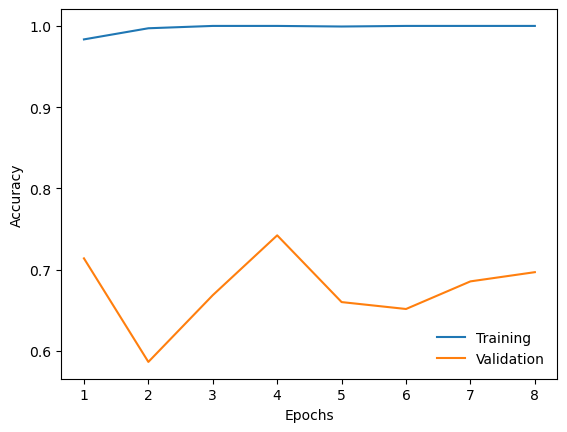

In [501]:
# PLOT HOW TRAINING AND VALIDATION ACCURACY CHANGE THROUGHOUT TRAINING PROCESS
plt.plot(range(1, best_n_epochs+1), best_history.history['accuracy'])
plt.plot(range(1, best_n_epochs+1), best_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, best_n_epochs+1))
plt.legend(['Training', 'Validation'], frameon=False)
plt.show()

## Best model

In [828]:
# define the model again (when rerunning the notebook)

In [592]:
IMAGE_SIZE = (224, 224)
n_nodes = 128
best_n_epochs = 8

# Create a new model
model = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(n_nodes, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification, so 1 neuron with sigmoid activation
])
        
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)
    
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=best_n_epochs)
    
# Report results
y_pred1 = model.predict(val_ds)
y_pred = np.round(y_pred1) # Binary
y_val = np.concatenate(list(val_ds.map(lambda x, y: y)))
print('F1 score: ', f1_score(y_val, y_pred, average="weighted"))

Epoch 1/8
44/44 [==============================] - 63s 1s/step - loss: 0.1653 - accuracy: 0.9841 - val_loss: 70.5248 - val_accuracy: 0.5127
Epoch 2/8
44/44 [==============================] - 60s 1s/step - loss: 0.0651 - accuracy: 0.9978 - val_loss: 27.4723 - val_accuracy: 0.7422
Epoch 3/8
44/44 [==============================] - 76s 2s/step - loss: 0.0110 - accuracy: 0.9986 - val_loss: 16.6736 - val_accuracy: 0.7167
Epoch 4/8
44/44 [==============================] - 96s 2s/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 60.7511 - val_accuracy: 0.6006
Epoch 5/8
44/44 [==============================] - 90s 2s/step - loss: 8.2912e-16 - accuracy: 1.0000 - val_loss: 56.4890 - val_accuracy: 0.6912
Epoch 6/8
44/44 [==============================] - 61s 1s/step - loss: 7.8105e-22 - accuracy: 1.0000 - val_loss: 55.7815 - val_accuracy: 0.7082
Epoch 7/8
44/44 [==============================] - 79s 2s/step - loss: 8.2405e-28 - accuracy: 1.0000 - val_loss: 56.0703 - val_accuracy: 0.7195
Epoch 8/

In [594]:
# F1 SCORE AND CLASSIFICATION REPORT FOR VALIDATION DATA
y_pred1 = model.predict(val_ds)
y_pred = np.round(y_pred1) # Binary
    
X_train = np.concatenate(list(train_ds.map(lambda x, y: x)))
y_train = np.concatenate(list(train_ds.map(lambda x, y: y)))
X_val = np.concatenate(list(val_ds.map(lambda x, y: x)))
y_val = np.concatenate(list(val_ds.map(lambda x, y: y)))

print(classification_report(y_val, y_pred, target_names=class_names))

12/12 [==============================] - 11s 870ms/step
              precision    recall  f1-score   support

        bird       0.39      0.66      0.49       137
       drone       0.61      0.33      0.43       216

    accuracy                           0.46       353
   macro avg       0.50      0.50      0.46       353
weighted avg       0.52      0.46      0.45       353



## Testing

### Load test data

In [483]:
# Load test data 
data_dir = pathlib.Path('test').with_suffix('')
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), seed=0)
class_names = test_ds.class_names
print('Names of classes:', class_names)

Found 104 files belonging to 2 classes.
Names of classes: ['bird', 'drone']


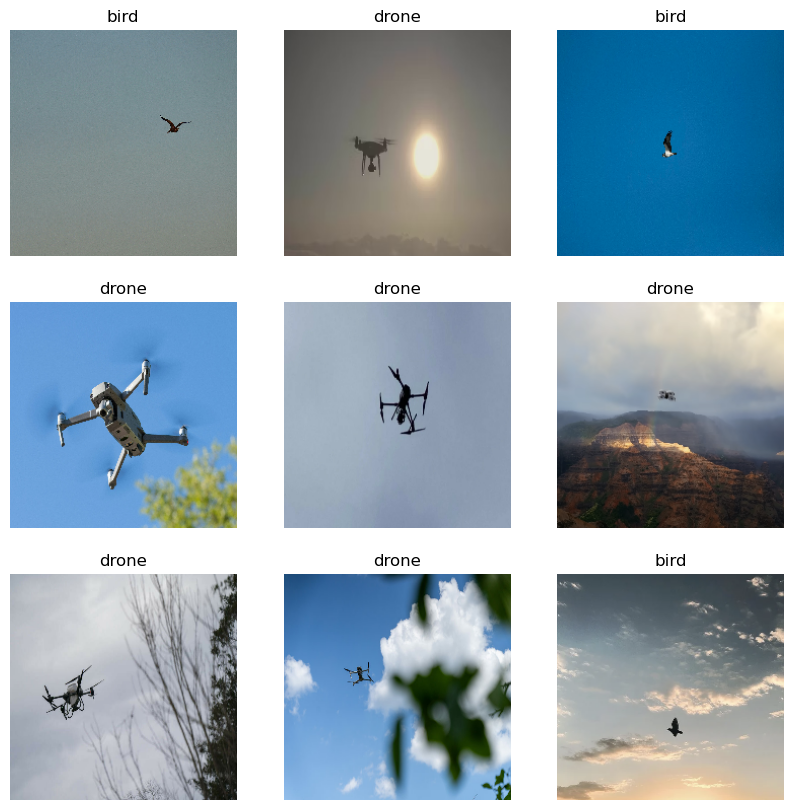

In [485]:
# DISPLAY EXAMPLE IMAGES

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Testing simple CNN

In [558]:
# F1 SCORE AND CLASSIFICATION REPORT FOR TESTING DATA
y_pred1 = simple_CNN_model.predict(test_ds)
y_pred = np.round(y_pred1) # Binary
    
X_val = np.concatenate(list(test_ds.map(lambda x, y: x)))
y_val = np.concatenate(list(test_ds.map(lambda x, y: y)))

print('F1 score: ', f1_score(y_val, y_pred, average="weighted"))
print('Accuracy score: ', accuracy_score(y_val, y_pred))

print(classification_report(y_val, y_pred, target_names=class_names))


4/4 [==============================] - 4s 327ms/step
F1 score:  0.4654193175245807
Accuracy score:  0.5096153846153846
              precision    recall  f1-score   support

        bird       0.50      0.80      0.62        51
       drone       0.55      0.23      0.32        53

    accuracy                           0.51       104
   macro avg       0.52      0.52      0.47       104
weighted avg       0.52      0.51      0.47       104



1/1 [==============================] - 0s 30ms/step


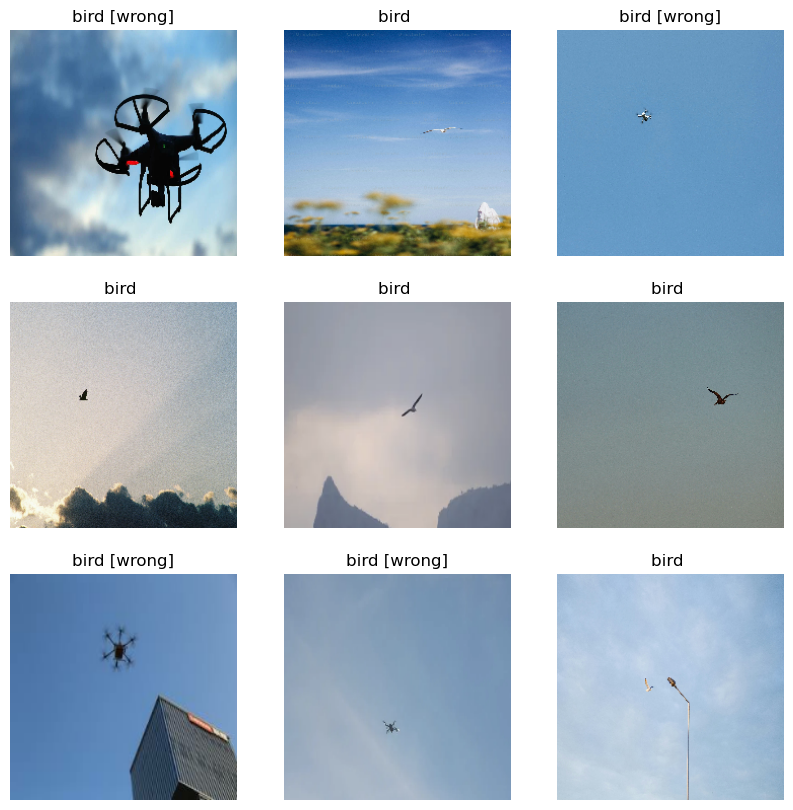

In [586]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        image = np.expand_dims(images[i], axis=0)
        y_pred1 = simple_CNN_model.predict(image)
        y_pred = int(np.round(y_pred1)[0][0]) # Binary
        t = "" if y_pred == labels[i] else "[wrong]" 
        plt.title(class_names[y_pred]+ " " + t)
        plt.axis("off")

### Testing fine-tuned ResNet50

In [596]:
# F1 SCORE AND CLASSIFICATION REPORT FOR TESTING DATA
y_pred1 = model.predict(test_ds)
y_pred = np.round(y_pred1) # Binary
    
X_val = np.concatenate(list(test_ds.map(lambda x, y: x)))
y_val = np.concatenate(list(test_ds.map(lambda x, y: y)))

print(classification_report(y_val, y_pred, target_names=class_names))

4/4 [==============================] - 6s 651ms/step
              precision    recall  f1-score   support

        bird       0.49      0.80      0.61        51
       drone       0.50      0.19      0.27        53

    accuracy                           0.49       104
   macro avg       0.49      0.50      0.44       104
weighted avg       0.49      0.49      0.44       104



In [598]:
print('F1 score: ', f1_score(y_val, y_pred, average="weighted"))
print('Accuracy score: ', accuracy_score(y_val, y_pred))


F1 score:  0.4374839011825313
Accuracy score:  0.49038461538461536


1/1 [==============================] - 0s 48ms/step


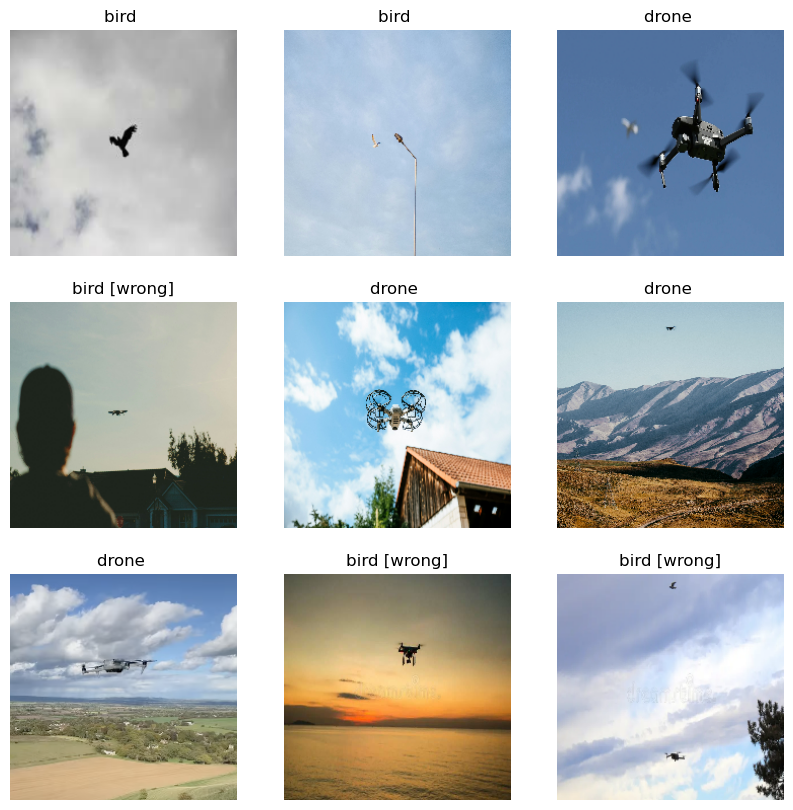

In [620]:

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        image = np.expand_dims(images[i], axis=0)
        y_pred1 = model.predict(image)
        y_pred = int(np.round(y_pred1)[0][0]) # Binary
        t = "" if y_pred == labels[i] else "[wrong]" #print("A") if a > b else print("=")
        plt.title(class_names[y_pred]+ " " + t)
        plt.axis("off")

### Testing ViT

In [774]:
# pip install roboflow scikit-learn

In [646]:
from roboflow import Roboflow
from sklearn.metrics import f1_score
import os

In [644]:
# Get the Roboflow Model using API and project id
#rf = Roboflow(api_key="") 
project = rf.workspace().project("drone-vs-bird-2-cumnq")
model = project.version(6).model

loading Roboflow workspace...
loading Roboflow project...


In [730]:
#Predict testing data
drone_predictions = []
bird_predictions = []

test_dir = pathlib.Path('test').with_suffix('')
for class_name in os.listdir(test_dir):
    print(class_name)
    img_dir = os.path.join(test_dir, class_name)
    if class_name == ".DS_Store":
        print("leaving")
        continue
    for filename in os.listdir(img_dir):
        #print("processing file" + filename)
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(img_dir, filename)
            try:
                prediction = model.predict(img_path)
                if class_name == "drone":
                    drone_predictions.append(prediction.json())
                elif class_name == "bird":
                    bird_predictions.append(prediction.json())
            except:
                print("can't read image " + img_path)

.DS_Store
leaving
drone
can't read image test/drone/colin-watts-Ig8QHE96JnQ-unsplash.jpg
can't read image test/drone/zoshua-colah-T8nGldduE9g-unsplash.jpg
can't read image test/drone/zoshua-colah-pCvoA3C4JUU-unsplash.jpg
bird
can't read image test/bird/vivek-doshi-vVRVt2e1gS4-unsplash.jpg
can't read image test/bird/jay-alexander-IZkjN4lrHRE-unsplash.jpg
can't read image test/bird/yuriy-vertikov-y_VCwEsDnBk-unsplash.jpg
can't read image test/bird/ellen-volkova-Kcw614Tb35I-unsplash.jpg


In [766]:
drone_preds = [pred["predictions"][0]["predictions"][0]["class"] for pred in drone_predictions]
tp_drone = drone_preds.count("drone")
drone_count = len(drone_preds)
print("Accuracy for ", drone_count, "drone images is" , (tp_drone / drone_count))

Accuracy for  50 drone images is 0.6


In [764]:
bird_preds = [pred["predictions"][0]["predictions"][0]["class"] for pred in bird_predictions]
tp_bird = bird_preds.count("bird")
bird_count = len(bird_preds)
print("Accuracy for", bird_count, "bird images is" , (tp_bird / bird_count))

Accuracy for 47 bird images is 0.851063829787234


In [830]:
 print("Weighted accuracy is", (0.6 * drone_count + 0.851063829787234 * bird_count) / (drone_count + bird_count))

Weighted accuracy is 0.7216494845360825


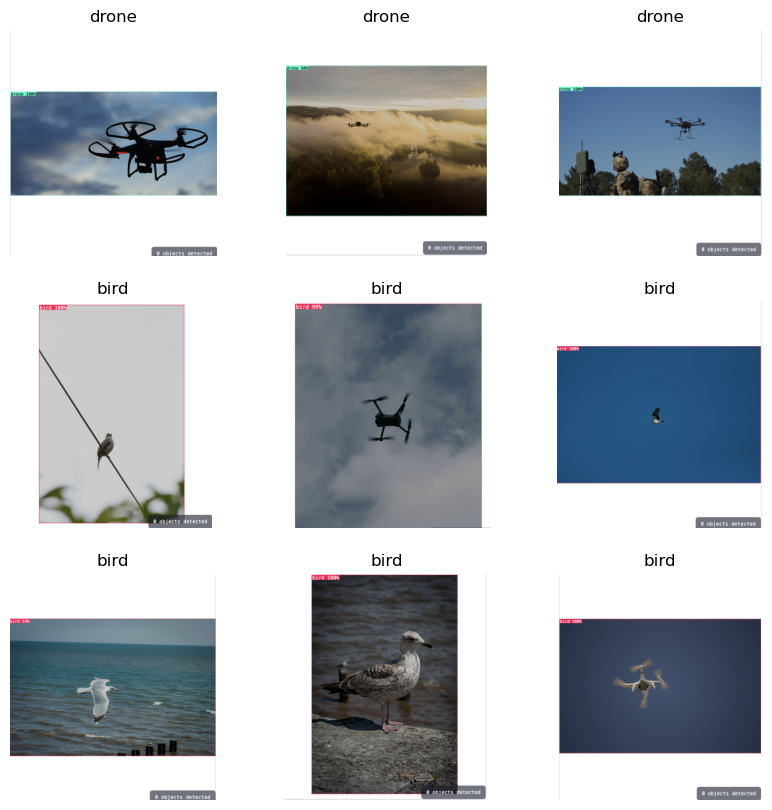

In [821]:
# Display preload predictions from Roboflow in vit_pred 
plt.figure(figsize=(10, 10))
vit_preds = pathlib.Path('vit_preds').with_suffix('')
i = 0
for filename in os.listdir(vit_preds):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        ax = plt.subplot(3, 3, i + 1)
        img_path = os.path.join(vit_preds, filename)
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title("drone" if "drone" in filename else "bird")
        plt.axis("off")
        i += 1